In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions

from spectral_cube import SpectralCube
import importlib as imp

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC


In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
import moment_maker as mm
from jwst_plots import JWSTCatalog, make_cat_use
import cutout_manager as cm
import jwst_plots
imp.reload(jwst_plots)

<module 'jwst_plots' from '/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/jwst_plots.py'>

In [4]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


## Catalog

In [5]:
cat_use = make_cat_use()

In [6]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

In [7]:
cutout_405 = cm.get_cutout_405(pos, w, l)
ww = cutout_405.wcs
data = cutout_405.data
blank_cutout = np.zeros_like(data)*np.nan

In [8]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], ww))

# Extinction

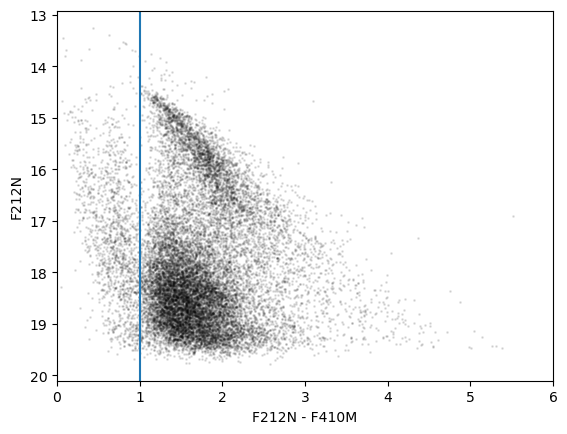

In [9]:
ax = plt.subplot(111)
cat_filament.plot_CMD('f212n', 'f410m', 'f212n', color='k', s=1, alpha=0.1, ax=ax)
ax.set_xlim(0, 6)
ax.axvline(1)

Text(0, 0.5, 'A$_V$ 212/410')

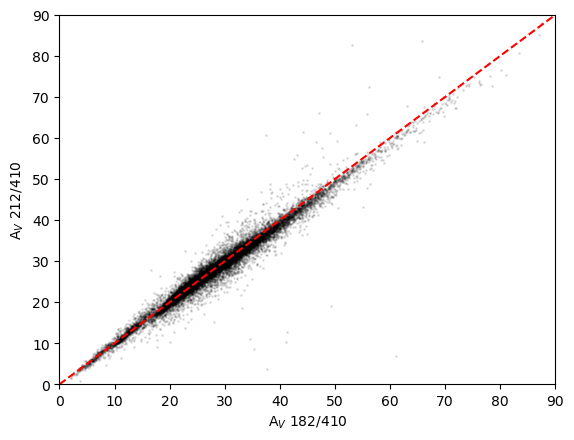

In [10]:
ax = plt.subplot(111)
Av_182410 = cat_filament.get_Av_182410()
Av_212410 = cat_filament.get_Av_212410()

ax.scatter(Av_182410, Av_212410, s=1, alpha=0.1, color='k')
ax.plot([0, 90], [0, 90], 'r--')
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)
ax.set_xlabel('A$_V$ 182/410')
ax.set_ylabel('A$_V$ 212/410')

<Axes: xlabel='F410M - F466N', ylabel='F410M'>

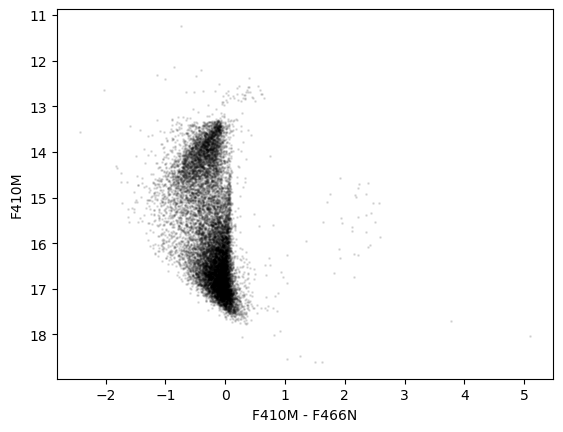

In [11]:
cat_filament.plot_CMD('f410m', 'f466n', 'f410m', color='k', s=1, alpha=0.1, label='Filament')

<Axes: xlabel='F212N - F410M', ylabel='F410M - F466N'>

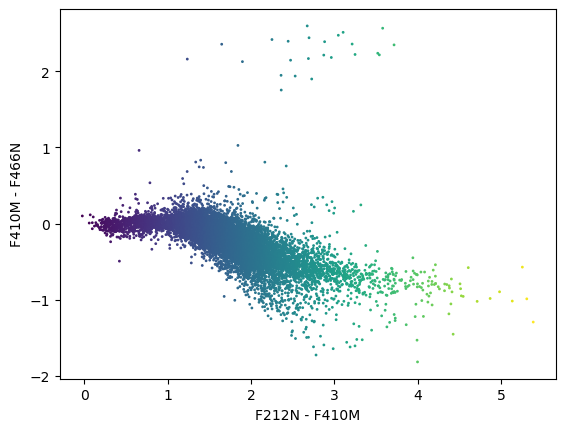

In [12]:
cat_filament.plot_CCD('f212n', 'f410m', 'f410m', 'f466n', c=cat_filament.color('f212n', 'f410m'), s=1, alpha=1, label='Filament')

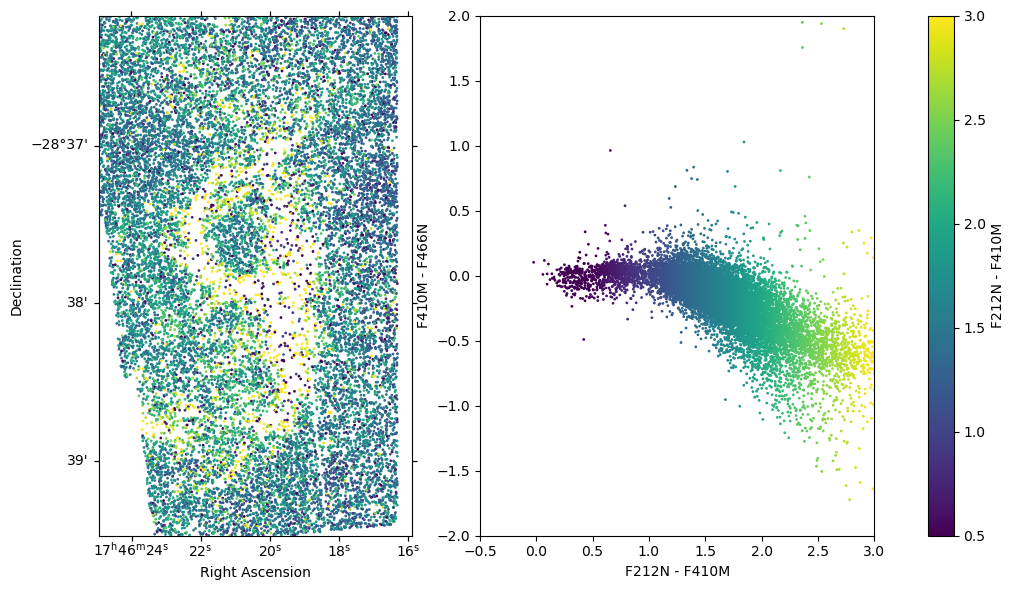

In [13]:
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121, projection=ww)
ax1.imshow(blank_cutout)
im = ax1.scatter(cat_filament.ra, cat_filament.dec, transform=ax1.get_transform('world'), s=1, c=cat_filament.color('f212n', 'f410m'), alpha=1, vmin=0.5, vmax=3)
ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination')

ax2 = plt.subplot(122)
cat_filament.plot_CCD('f212n', 'f410m', 'f410m', 'f466n', c=cat_filament.color('f212n', 'f410m'), s=1, alpha=1, ax=ax2, vmin=0.5, vmax=3)
ax2.set_xlim(-0.5, 3)
ax2.set_ylim(-2, 2)

plt.tight_layout()
fig.colorbar(im, ax=(ax1,ax2), label='F212N - F410M')

In [14]:
# Estimate Av using F212N - F410M / ext(F212N - F410M)
Av_212410 = cat_filament.get_Av_212410()

# CO

In [15]:
import icemodels
imp.reload(icemodels)
from icemodels import absorbed_spectrum, absorbed_spectrum_Gaussians, convsum, fluxes_in_filters, load_molecule, load_molecule_ocdb, atmo_model, molecule_data
from icemodels.gaussian_model_components import co_ice_wls_icm, co_ice_wls, co_ice_widths, co_ice_bandstrength
co_ice_wls, co_ice_widths

(<Quantity [4.66483183, 4.67311557, 4.68055231] um>,
 <Quantity [0.0065282 , 0.0076433 , 0.02322202] um>)

In [16]:
from astroquery.svo_fps import SvoFps
from astropy import table
filter_data = SvoFps.get_filter_list('JWST', instrument="NIRCam")
filter_data.add_index('filterID')
flxd = filter_data['filterID']
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

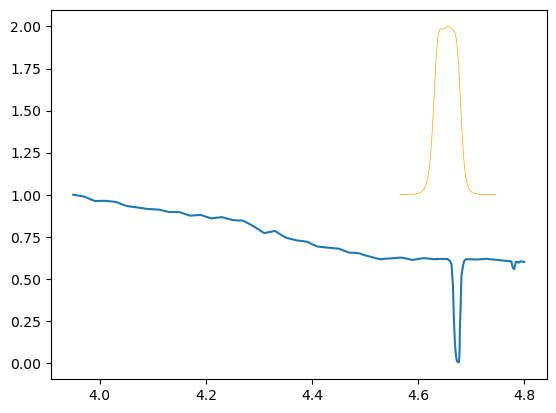

In [17]:
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)

aspec = absorbed_spectrum(1e18*u.cm**-2, load_molecule('co'), spectrum=phx4000['fnu'], xarr=xarr)
plt.plot(xarr.to(u.um), aspec / aspec.max())

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')

In [19]:
filterid = 'JWST/NIRCam.F466N'
xarr = np.linspace(filter_data.loc[filterid]['WavelengthMin'] * u.AA,
                   filter_data.loc[filterid]['WavelengthMax'] * u.AA,
                   1000)
xarr = np.linspace(3.95*u.um, 4.8*u.um, 5000)
phx4000 = atmo_model(4000, xarr=xarr)

aspec = absorbed_spectrum(1e18*u.cm**-2, load_molecule_ocdb('co'), spectrum=phx4000['fnu'], xarr=xarr)
plt.plot(xarr.to(u.um), aspec / aspec.max())

trans = SvoFps.get_transmission_data(filterid)
plt.plot(trans['Wavelength'].quantity.to(u.um),
        trans['Transmission'].value/trans['Transmission'].value.max() + 1,
        linewidth=0.5,
        color='orange')

InconsistentTableError: Number of header columns (2) inconsistent with data columns in data line 1

In [20]:
molecule = 'co'
# ocdb version gives nonsense
consts = load_molecule(molecule)
xarr = phx4000['nu'].quantity.to(u.um, u.spectral())
cols = np.geomspace(1e15, 1e22, 25)
dmags410 = []
dmags466 = []

print(f"  column,   mag410,  mag410*,  mag466n, mag466n*, dmag410, dmag466")
for col in cols:
    spec = absorbed_spectrum(col*u.cm**-2, consts, molecular_weight=molecule_data[molecule]['molwt'],
                              spectrum=phx4000['fnu'].quantity,
                              xarr=xarr,
                             )
    cmd_x = ('JWST/NIRCam.F410M', 'JWST/NIRCam.F466N')
    flxd_ref = fluxes_in_filters(xarr, phx4000['fnu'].quantity)
    flxd = fluxes_in_filters(xarr, spec)
    mags_x_star = (-2.5*np.log10(flxd_ref[cmd_x[0]] / u.Quantity(jfilts.loc[cmd_x[0]]['ZeroPoint'], u.Jy)),
                   -2.5*np.log10(flxd_ref[cmd_x[1]] / u.Quantity(jfilts.loc[cmd_x[1]]['ZeroPoint'], u.Jy)))
    mags_x = flxd[cmd_x[0]].to(u.ABmag).value, flxd[cmd_x[1]].to(u.ABmag).value
    dmags466.append(mags_x[1]-mags_x_star[1])
    dmags410.append(mags_x[0]-mags_x_star[0])
    # why would f410m change at all?
    print(f"{col:8.1g}, {mags_x[0]:8.1f}, {mags_x_star[0]:8.1f}, {mags_x[1]:8.1f}, {mags_x_star[1]:8.1f}, {dmags410[-1]:8.1f}, {dmags466[-1]:8.1f}")

  column,   mag410,  mag410*,  mag466n, mag466n*, dmag410, dmag466
   1e+15,    -11.0,    -14.1,    -10.6,    -14.0,      3.1,      3.4
   2e+15,    -11.0,    -14.1,    -10.6,    -14.0,      3.1,      3.4
   4e+15,    -11.0,    -14.1,    -10.6,    -14.0,      3.1,      3.4
   7e+15,    -11.0,    -14.1,    -10.6,    -14.0,      3.1,      3.4
   1e+16,    -11.0,    -14.1,    -10.6,    -14.0,      3.1,      3.4
   3e+16,    -11.0,    -14.1,    -10.6,    -14.0,      3.1,      3.4
   6e+16,    -11.0,    -14.1,    -10.6,    -14.0,      3.1,      3.4
   1e+17,    -11.0,    -14.1,    -10.5,    -14.0,      3.1,      3.4
   2e+17,    -11.0,    -14.1,    -10.5,    -14.0,      3.1,      3.5
   4e+17,    -11.0,    -14.1,    -10.5,    -14.0,      3.1,      3.5
   8e+17,    -11.0,    -14.1,    -10.4,    -14.0,      3.1,      3.6
   2e+18,    -11.0,    -14.1,    -10.3,    -14.0,      3.1,      3.7
   3e+18,    -11.0,    -14.1,    -10.3,    -14.0,      3.1,      3.7
   6e+18,    -11.0,    -14.1,    -10

## Plot N(CO) as a function of F466N-F410M

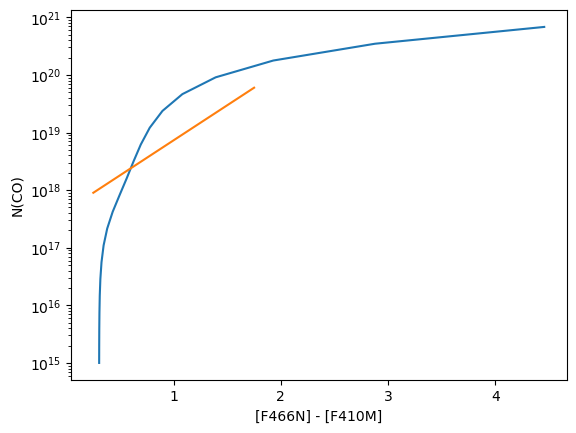

In [21]:
dmag_466m410 = np.array(dmags466) - np.array(dmags410) 
plt.semilogy(dmag_466m410[cols<1e21], cols[cols<1e21])
plt.xlabel('[F466N] - [F410M]')
plt.ylabel('N(CO)')
plt.plot([0.25, 1.75], [9e17, 6e19]);

In [22]:
slope = (np.log10(6e19) - np.log10(9e17)) / (1.75-0.25)
nco_uncert = slope * 0.1*np.sqrt(2)
slope, nco_uncert, 10**nco_uncert, 0.1*np.sqrt(2)

(1.2159391606295458,
 0.17195976519828612,
 1.4857979855607997,
 0.14142135623730953)

In [23]:
av212410 = cat_filament.color('f212n', 'f410m') / (CT06_MWLoc()(2.12*u.um) - CT06_MWLoc()(4.1*u.um))
av182212 = cat_filament.color('f182m', 'f212n') / (CT06_MWLoc()(1.82*u.um) - CT06_MWLoc()(2.12*u.um))
av182410 = cat_filament.color('f182m', 'f410m') / (CT06_MWLoc()(1.82*u.um) - CT06_MWLoc()(4.1*u.um))
av187405 = cat_filament.color('f187n', 'f405n') / (CT06_MWLoc()(1.87*u.um) - CT06_MWLoc()(4.05*u.um))

In [24]:
measured_466m410 = cat_filament.color('f466n', 'f410m')

In [25]:
unextincted_466m410_av212410 = measured_466m410 + (CT06_MWGC()(4.10*u.um) - CT06_MWGC()(4.66*u.um)) * av212410
inferred_co_column_av212410 = np.interp(unextincted_466m410_av212410, dmag_466m410[cols<1e21], cols[cols<1e21])

unextincted_466m410_av182212 = measured_466m410 + (CT06_MWGC()(4.10*u.um) - CT06_MWGC()(4.66*u.um)) * av182212
inferred_co_column_av182212 = np.interp(unextincted_466m410_av182212, dmag_466m410[cols<1e21], cols[cols<1e21])

unextincted_466m410_av182410 = measured_466m410 + (CT06_MWGC()(4.10*u.um) - CT06_MWGC()(4.66*u.um)) * av182410
inferred_co_column_av182410 = np.interp(unextincted_466m410_av182410, dmag_466m410[cols<1e21], cols[cols<1e21])

unextincted_466m410_av187405 = measured_466m410 + (CT06_MWGC()(4.10*u.um) - CT06_MWGC()(4.66*u.um)) * av187405
inferred_co_column_av187405 = np.interp(unextincted_466m410_av187405, dmag_466m410[cols<1e21], cols[cols<1e21])

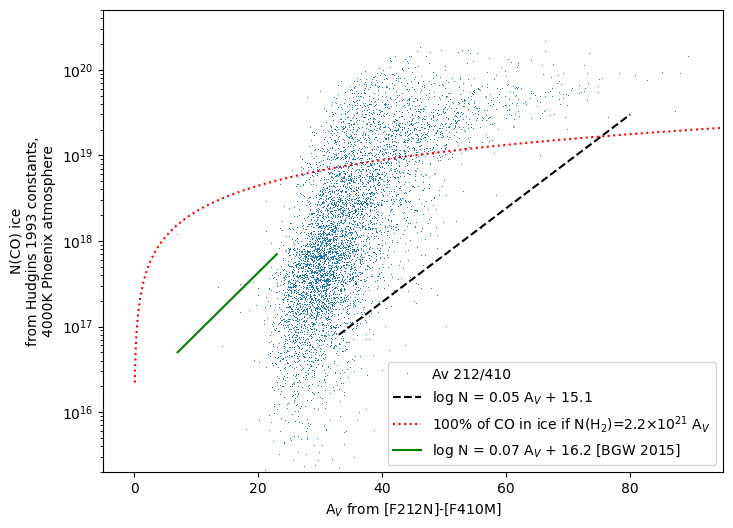

In [65]:
fig = plt.figure(figsize=(8,6))
plt.semilogy(av212410, inferred_co_column_av212410, marker=',', linestyle='none', label='Av 212/410')

NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
plt.xlim(-5, 95)
plt.ylim(2e15, 5e20)
#pl.plot([10, 35], [1e17, 1e20], 'k--', label='log N = 0.12 A$_V$ + 15.8');
# by-eye fit
x1,y1 = 10,2e17
x2,y2 = 43,1e19
x1,y1 = 33,8e16
x2,y2 = 80,3e19
m = (np.log10(y2) - np.log10(y1)) / (x2 - x1)
b = np.log10(y1 / 10**(m * x1))
plt.plot([x1, x2], 10**np.array([x1*m+b, x2*m+b]), 'k--', label=f'log N = {m:0.2f} A$_V$ + {b:0.1f}')
plt.plot(np.linspace(0.1, 100, 1000), NCOofAV,
        label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')
plt.plot([7, 23], [0.5e17, 7e17], 'g', label='log N = 0.07 A$_V$ + 16.2 [BGW 2015]')
plt.xlabel("A$_V$ from [F212N]-[F410M]")
plt.ylabel("N(CO) ice\nfrom Hudgins 1993 constants,\n4000K Phoenix atmosphere")
plt.legend()

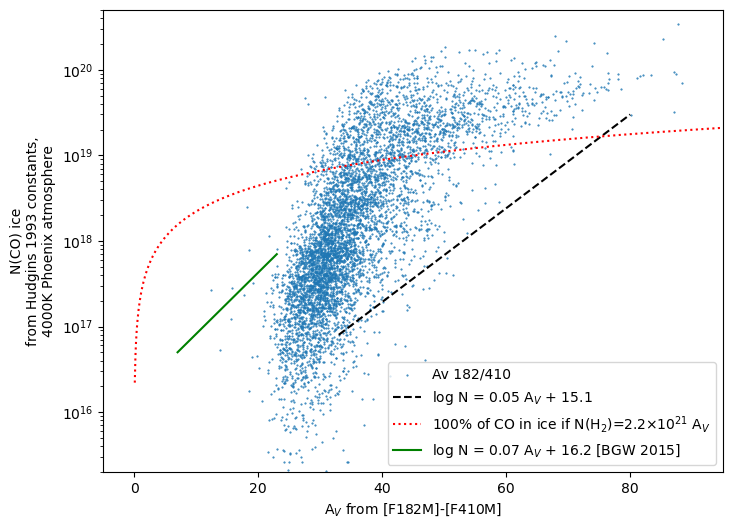

In [33]:
fig = plt.figure(figsize=(8,6))
plt.scatter(av182410, inferred_co_column_av182410, marker='.', label='Av 182/410', s=1)

NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
plt.xlim(-5, 95)
plt.ylim(2e15, 5e20)
#pl.plot([10, 35], [1e17, 1e20], 'k--', label='log N = 0.12 A$_V$ + 15.8');
# by-eye fit
x1,y1 = 10,2e17
x2,y2 = 43,1e19
x1,y1 = 33,8e16
x2,y2 = 80,3e19
m = (np.log10(y2) - np.log10(y1)) / (x2 - x1)
b = np.log10(y1 / 10**(m * x1))
plt.plot([x1, x2], 10**np.array([x1*m+b, x2*m+b]), 'k--', label=f'log N = {m:0.2f} A$_V$ + {b:0.1f}')
plt.plot(np.linspace(0.1, 100, 1000), NCOofAV,
        label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')
plt.plot([7, 23], [0.5e17, 7e17], 'g', label='log N = 0.07 A$_V$ + 16.2 [BGW 2015]')
plt.xlabel("A$_V$ from [F182M]-[F410M]")
plt.ylabel("N(CO) ice\nfrom Hudgins 1993 constants,\n4000K Phoenix atmosphere")
plt.yscale('log')
plt.legend()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_Av_vs_NCO_182410.pdf', bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_Av_vs_NCO_182410.png', bbox_inches='tight', dpi=300)

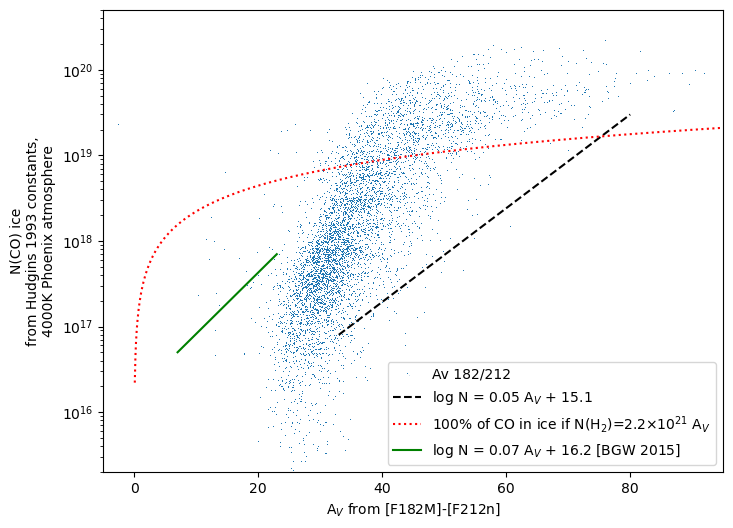

In [66]:
fig = plt.figure(figsize=(8,6))
plt.semilogy(av182212, inferred_co_column_av182212, marker=',', linestyle='none', label='Av 182/212')

NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
plt.xlim(-5, 95)
plt.ylim(2e15, 5e20)
#pl.plot([10, 35], [1e17, 1e20], 'k--', label='log N = 0.12 A$_V$ + 15.8');
# by-eye fit
x1,y1 = 10,2e17
x2,y2 = 43,1e19
x1,y1 = 33,8e16
x2,y2 = 80,3e19
m = (np.log10(y2) - np.log10(y1)) / (x2 - x1)
b = np.log10(y1 / 10**(m * x1))
plt.plot([x1, x2], 10**np.array([x1*m+b, x2*m+b]), 'k--', label=f'log N = {m:0.2f} A$_V$ + {b:0.1f}')
plt.plot(np.linspace(0.1, 100, 1000), NCOofAV,
        label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')
plt.plot([7, 23], [0.5e17, 7e17], 'g', label='log N = 0.07 A$_V$ + 16.2 [BGW 2015]')
plt.xlabel("A$_V$ from [F182M]-[F212n]")
plt.ylabel("N(CO) ice\nfrom Hudgins 1993 constants,\n4000K Phoenix atmosphere")
plt.legend()

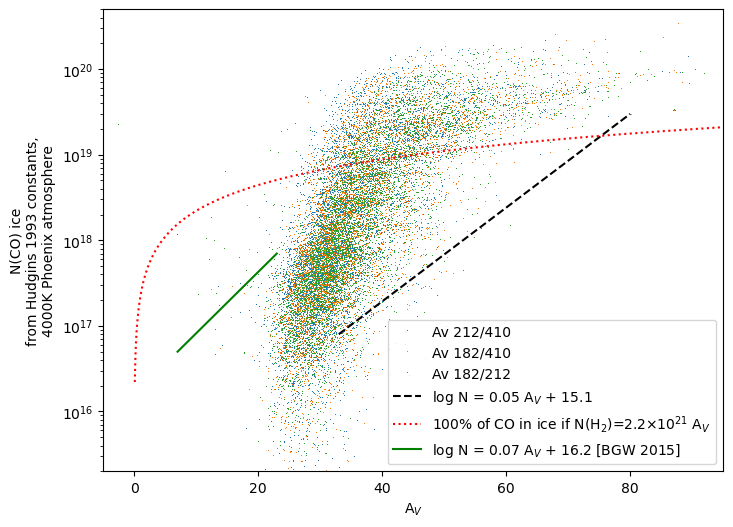

In [67]:
fig = plt.figure(figsize=(8,6))
plt.semilogy(av212410, inferred_co_column_av212410, marker=',', linestyle='none', label='Av 212/410')
plt.semilogy(av182410, inferred_co_column_av182410, marker=',', linestyle='none', label='Av 182/410')
plt.semilogy(av182212, inferred_co_column_av182212, marker=',', linestyle='none', label='Av 182/212')

NCOofAV = 2.21e21 * np.linspace(0.1, 100, 1000) * 1e-4
plt.xlim(-5, 95)
plt.ylim(2e15, 5e20)
#pl.plot([10, 35], [1e17, 1e20], 'k--', label='log N = 0.12 A$_V$ + 15.8');
# by-eye fit
x1,y1 = 10,2e17
x2,y2 = 43,1e19
x1,y1 = 33,8e16
x2,y2 = 80,3e19
m = (np.log10(y2) - np.log10(y1)) / (x2 - x1)
b = np.log10(y1 / 10**(m * x1))
plt.plot([x1, x2], 10**np.array([x1*m+b, x2*m+b]), 'k--', label=f'log N = {m:0.2f} A$_V$ + {b:0.1f}')
plt.plot(np.linspace(0.1, 100, 1000), NCOofAV,
        label='100% of CO in ice if N(H$_2$)=2.2$\\times10^{21}$ A$_V$', color='r', linestyle=':')
plt.plot([7, 23], [0.5e17, 7e17], 'g', label='log N = 0.07 A$_V$ + 16.2 [BGW 2015]')
plt.xlabel("A$_V$")
plt.ylabel("N(CO) ice\nfrom Hudgins 1993 constants,\n4000K Phoenix atmosphere")
plt.legend()

# Old

## CO Files

In [6]:
fn_12CO = '/orange/adamginsburg/cmz/nobeyama/12CO-2.BEARS.FITS'
fn_13CO = '/orange/adamginsburg/cmz/nobeyama/13CO-2.FOREST.FITS'
fn_C18O = '/orange/adamginsburg/cmz/nobeyama/C18O-2.FOREST.FITS'

In [7]:
cube_12CO = SpectralCube.read(fn_12CO, format='fits')
cube_13CO = SpectralCube.read(fn_13CO, format='fits')
cube_C18O = SpectralCube.read(fn_C18O, format='fits')

In [8]:
subcube_12CO = cube_12CO.spectral_slab(-56*u.km/u.s, -54*u.km/u.s)
subcube_13CO = cube_13CO.spectral_slab(-56*u.km/u.s, -54*u.km/u.s)
subcube_C18O = cube_C18O.spectral_slab(-56*u.km/u.s, -54*u.km/u.s)

In [9]:
reg = Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/f4_fov_cloudc.reg')

In [10]:
mom0_12CO = subcube_12CO.subcube_from_regions(reg).moment0()
mom0_13CO = subcube_13CO.subcube_from_regions(reg).moment0()
mom0_C18O = subcube_C18O.subcube_from_regions(reg).moment0()

## Catalog

In [11]:
cat_use = make_cat_use()

In [12]:
reg_filament = Regions.read(f'../regions_/filament_short.region')

cat_filament = JWSTCatalog(cat_use.table_region_mask(reg_filament, wcs=mom0_12CO.wcs))

In [36]:
basetable = cat_filament.catalog

## Av

In [37]:
from dust_extinction.averages import CT06_MWGC
av182410 = (basetable['mag_ab_f182m'] - basetable['mag_ab_f410m']) / (CT06_MWGC()(1.82*u.um) - CT06_MWGC()(4.10*u.um))
a182 = CT06_MWGC()(1.82*u.um)
f182mdr = basetable['mag_ab_f182m'] - a182 * av182410

## Select Region of CO Data

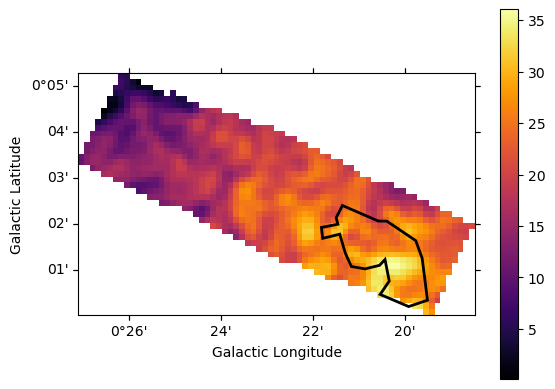

In [38]:
ax = plt.subplot(projection=mom0_12CO.wcs)
im = ax.imshow(mom0_12CO.value, origin='lower', cmap='inferno', norm=simple_norm(mom0_12CO.value, stretch='linear', max_percent=99.9))
plt.colorbar(im)
#reg[0].to_pixel(mom0_12CO.wcs).plot(ax=ax, edgecolor='k')
reg_filament[0].to_pixel(mom0_12CO.wcs).plot(ax=ax, edgecolor='k')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')

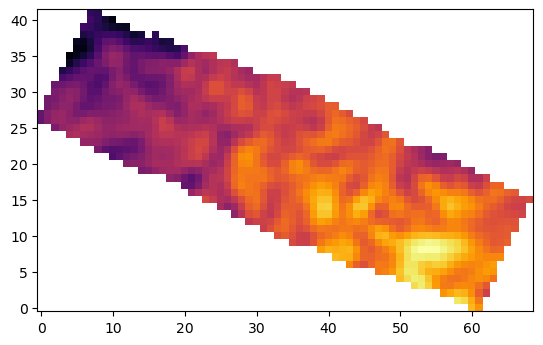

In [39]:
#ax = plt.subplot(projection=mom0_12CO.wcs)
im = plt.imshow(mom0_12CO.value, origin='lower', cmap='inferno', norm=simple_norm(mom0_12CO.value, stretch='linear', max_percent=99.9))
#plt.colorbar(im)
#reg[0].to_pixel(mom0_12CO.wcs).plot(ax=ax, edgecolor='k')
#plt.xlabel('Galactic Longitude')
#plt.ylabel('Galactic Latitude')

In [40]:
ww_12CO = mom0_12CO.wcs
crds_pix_12CO = np.array(ww_12CO.world_to_pixel(basetable['skycoord_ref']))

ww_13CO = mom0_13CO.wcs
crds_pix_13CO = np.array(ww_13CO.world_to_pixel(basetable['skycoord_ref']))

ww_C18O = mom0_C18O.wcs
crds_pix_C18O = np.array(ww_C18O.world_to_pixel(basetable['skycoord_ref']))

In [41]:
tbl = basetable.copy()
#tbl['W_12CO'] = 
tbl['mom0_12CO'] = mom0_12CO.value[crds_pix_12CO[1].astype(int), crds_pix_12CO[0].astype(int)]
tbl['mom0_13CO'] = mom0_13CO.value[crds_pix_13CO[1].astype(int), crds_pix_13CO[0].astype(int)]
tbl['mom0_C18O'] = mom0_C18O.value[crds_pix_C18O[1].astype(int), crds_pix_C18O[0].astype(int)]
tbl['Av'] = av182410
tbl['182m410'] = tbl['mag_ab_f182m'] - tbl['mag_ab_f410m']
tbl['H2 cm-2'] = tbl['mom0_12CO']*2e20*u.cm**-2/(u.K*u.km/u.s)

Text(0, 0.5, '12CO Moment 0 (K km/s)')

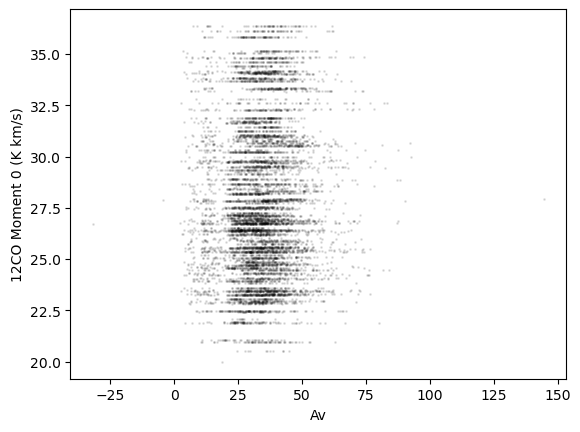

In [47]:
plt.scatter(tbl['Av'], tbl['mom0_12CO'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('12CO Moment 0 (K km/s)')
#plt.xlim(0, 60)

Text(0, 0.5, '13CO Moment 0 (K km/s)')

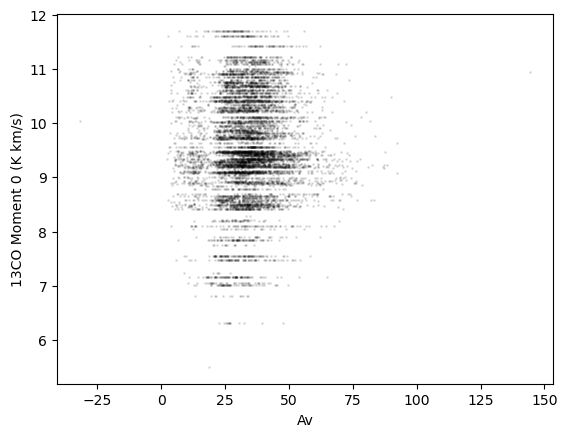

In [48]:
plt.scatter(tbl['Av'], tbl['mom0_13CO'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('13CO Moment 0 (K km/s)')
#plt.xlim(0, 60)

Text(0, 0.5, 'C18O Moment 0 (K km/s)')

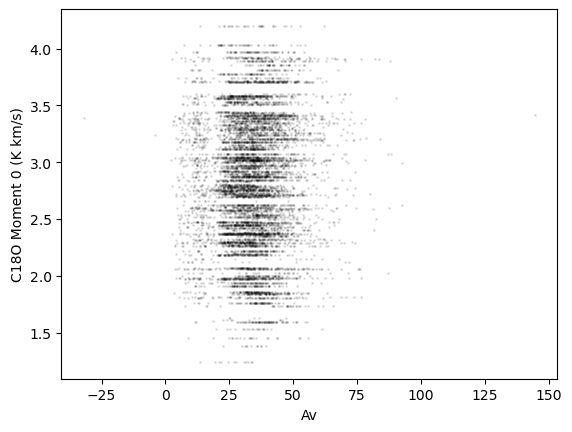

In [49]:
plt.scatter(tbl['Av'], tbl['mom0_C18O'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('C18O Moment 0 (K km/s)')
#plt.xlim(0, 60)

Text(0, 0.5, 'H2 cm-2 (X_CO = 2e20 cm-2/(K km/s))')

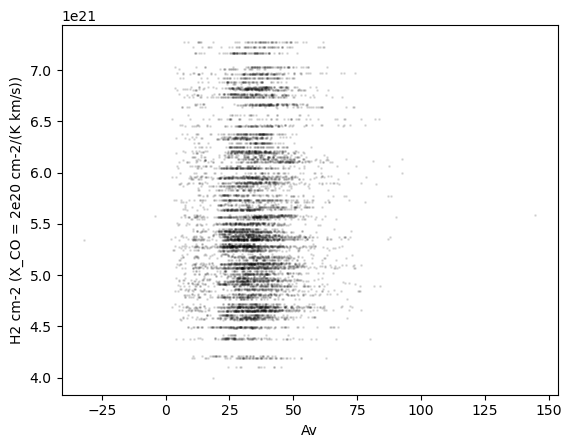

In [50]:
plt.scatter(tbl['Av'], tbl['H2 cm-2'], s=1, alpha=0.1, color='k')
plt.xlabel('Av')
plt.ylabel('H2 cm-2 (X_CO = 2e20 cm-2/(K km/s))')
#plt.xlim(0, 60)

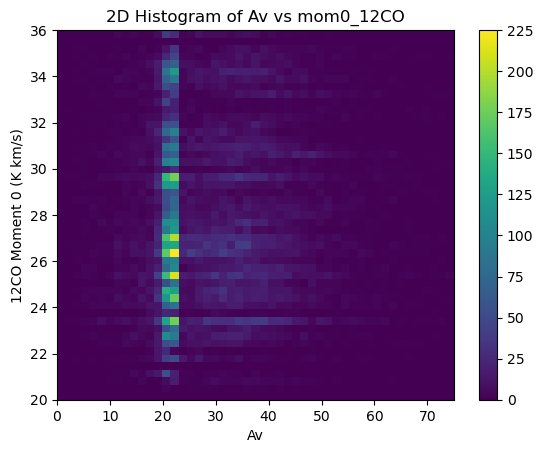

In [46]:
xbins = np.linspace(0, 75, 50)
ybins = np.linspace(20, 36, 50)

h, xedges, yedges = np.histogram2d(tbl['Av'], tbl['mom0_12CO'], bins=[xbins, ybins])

plt.imshow(h.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', origin='lower')#, norm=simple_norm(h, stretch='log', max_percent=99.9))

plt.colorbar()
plt.xlabel('Av')
plt.ylabel('12CO Moment 0 (K km/s)')
plt.title('2D Histogram of Av vs mom0_12CO')
plt.show()